In [1]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim
import dask
from dask.distributed import Client

# Configure Dask
client = Client(
    n_workers=20,        # or match number of physical cores
    threads_per_worker=2,
    memory_limit="10GB"  # per worker (8 * 10GB = 80GB total)
)
with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            "shapefile=/beegfs/muduchuru/codes/python/climadata_yield/afg.shp",
            f"time_range.start_date=2020-01-02",
            f"time_range.end_date=2020-01-31",
            "mappings.mswx.params.google_service_account=/home/muduchuru/.climdata_conf/service.json",
            "+shp_name=afg",
            ]
    )

ds_vars = []
extract_kwargs = {}
extract_kwargs["shapefile"] = cfg.shapefile
# Loop over variables in config
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    mswx = climdata.MSWX(cfg)
    mswx.load(var)
    mswx.extract(**extract_kwargs)
    ds_vars.append(mswx.dataset)

# Merge all variables into one dataset
ds = xr.merge(ds_vars)

# # # Save NetCDF
# region_bounds = cfg.bounds[cfg.region]
# filename = cfg.output.filename_nc.format(
#         provider=cfg.dataset,
#         parameter = "surface",
#         lat_range=f"{region_bounds['lat_min']}-{region_bounds['lat_max']}",
#         lon_range=f"{region_bounds['lon_min']}-{region_bounds['lon_max']}",
#         start=cfg.time_range.start_date.replace("-", ""),
#         end=cfg.time_range.end_date.replace("-", ""),
#     )
# print(f"💾 Saving merged dataset to {filename}")
# for var in ds.data_vars:
#     ds[var] =  xclim.core.units.convert_units_to(
#         ds[var], cfg.mappings["info"][var].units
#     )
# ds.to_netcdf(filename)

📂 Processing variable: tasmin
✅ All 30 tasmin files already exist locally.
📂 Processing variable: tasmax
✅ All 30 tasmax files already exist locally.
📂 Processing variable: pr
✅ All 30 pr files already exist locally.


In [5]:
ds

<xarray.Dataset> Size: 156MB
Dimensions:      (lat: 90, time: 30, lon: 142, geom_id: 34)
Coordinates:
  * lat          (lat) float32 360B 29.45 29.55 29.65 ... 38.15 38.25 38.35
  * time         (time) datetime64[ns] 240B 2020-01-02 2020-01-03 ... 2020-01-31
  * lon          (lon) float32 568B 60.55 60.65 60.75 ... 74.45 74.55 74.65
  * geom_id      (geom_id) int64 272B 0 1 2 3 4 5 6 7 ... 27 28 29 30 31 32 33
    spatial_ref  int64 8B 0
Data variables:
    tasmin       (geom_id, time, lat, lon) float32 52MB dask.array<chunksize=(1, 1, 6, 6), meta=np.ndarray>
    tasmax       (geom_id, time, lat, lon) float32 52MB dask.array<chunksize=(1, 1, 6, 6), meta=np.ndarray>
    pr           (geom_id, time, lat, lon) float32 52MB dask.array<chunksize=(1, 1, 6, 6), meta=np.ndarray>

In [5]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=1989-01-01",
            f"time_range.end_date=2020-12-31",
            "lat=52",
            "lon=14",
            ]
    )

ds_vars = []
# Loop over variables in config
for var in cfg.variables:            
    dwd = climdata.DWD(cfg)
    lat, lon = cfg.lat, cfg.lon
    dwd.load(var, lat, lon,buffer_km=30)

In [6]:
dwd.df

,station_id,resolution,dataset,parameter,date,value,quality
0,03083,daily,climate_summary,precipitation_height,1991-10-01 00:00:00+00:00,0.3,10.0
1,03083,daily,climate_summary,precipitation_height,1991-10-02 00:00:00+00:00,0.7,10.0
2,03083,daily,climate_summary,precipitation_height,1991-10-03 00:00:00+00:00,0.0,10.0
3,03083,daily,climate_summary,precipitation_height,1991-10-04 00:00:00+00:00,0.0,10.0
4,03083,daily,climate_summary,precipitation_height,1991-10-05 00:00:00+00:00,0.0,10.0
...,...,...,...,...,...,...,...
24666,03015,daily,climate_summary,precipitation_height,2020-12-27 00:00:00+00:00,0.0,9.0
24667,03015,daily,climate_summary,precipitation_height,2020-12-28 00:00:00+00:00,0.5,9.0
24668,03015,daily,climate_summary,precipitation_height,2020-12-29 00:00:00+00:00,0.4,9.0
24669,03015,daily,climate_summary,precipitation_height,2020-12-30 00:00:00+00:00,0.0,9.0


In [28]:
from wetterdienst.provider.dwd.observation import DwdObservationRequest

request = DwdObservationRequest(
    parameters=[("daily", "kl"), ("daily", "solar")],
    start_date="2010-01-01",
    end_date="2025-01-01",
)

In [32]:
df_dwd = request.all().df.to_pandas()
df_dwd[df_dwd["end_date"] > "2020-01-01"]

,resolution,dataset,station_id,start_date,end_date,latitude,longitude,height,name,state
2,daily,climate_summary,00011,1980-09-01 00:00:00+00:00,2025-10-05 00:00:00+00:00,47.9736,8.5205,680.0,Donaueschingen (Landeplatz),Baden-Württemberg
3,daily,climate_summary,00044,1969-01-01 00:00:00+00:00,2025-10-05 00:00:00+00:00,52.9336,8.2370,44.0,Großenkneten,Niedersachsen
9,daily,climate_summary,00073,1959-03-01 00:00:00+00:00,2025-10-05 00:00:00+00:00,48.6183,13.0620,374.0,Aldersbach-Kramersepp,Bayern
10,daily,climate_summary,00078,1961-01-01 00:00:00+00:00,2025-10-05 00:00:00+00:00,52.4853,7.9125,64.0,Alfhausen,Niedersachsen
11,daily,climate_summary,00090,1988-02-19 00:00:00+00:00,2025-10-05 00:00:00+00:00,50.7557,9.2583,305.0,Alsfeld,Hessen
...,...,...,...,...,...,...,...,...,...,...
1308,daily,climate_summary,19207,2023-04-01 00:00:00+00:00,2025-10-05 00:00:00+00:00,53.8178,12.0645,16.0,Gülzow-Prüzen,Mecklenburg-Vorpommern
1309,daily,climate_summary,19243,2024-01-01 00:00:00+00:00,2025-10-05 00:00:00+00:00,54.6831,8.4721,8.0,Föhr,Schleswig-Holstein
1316,daily,climate_summary,19576,2023-09-01 00:00:00+00:00,2023-09-08 00:00:00+00:00,49.8044,8.8582,249.0,Reinheim-Hundertmorgen,Hessen
1329,daily,climate_summary,19856,2024-08-01 00:00:00+00:00,2025-10-05 00:00:00+00:00,47.6134,12.9819,625.0,Schönau am Königssee,Bayern


In [28]:
import xarray as xr

# Step 1: Apply threshold
mask = ds['pr'] > 50

# Step 2: Stack coordinates into a single dimension (Dask-safe)
exceeding = ds['pr'].where(mask).stack(points=("time", "lat", "lon"))

# Step 3: Drop NaN values
exceeding = exceeding.dropna("points")

# Step 4: Compute only the filtered data
exceeding = exceeding.compute()

# Step 5: Convert to DataFrame (no reset_index!)
exceeding_df = exceeding.to_dataframe(name="pr")['pr'].reset_index()

exceeding_df


,time,lat,lon,pr
0,1989-01-01,42.049999,42.749996,56.0625
1,1989-01-01,42.150002,42.749996,50.8750
2,1989-01-01,42.250000,42.650005,51.1875
3,1989-01-01,42.250000,42.850002,51.4375
4,1989-01-02,66.449997,32.450008,50.5625
...,...,...,...,...
1034434,2020-12-30,42.150002,19.450008,72.4375
1034435,2020-12-30,42.250000,18.749996,58.6250
1034436,2020-12-30,42.349998,19.049999,50.2500
1034437,2020-12-30,42.549999,19.249996,51.2500


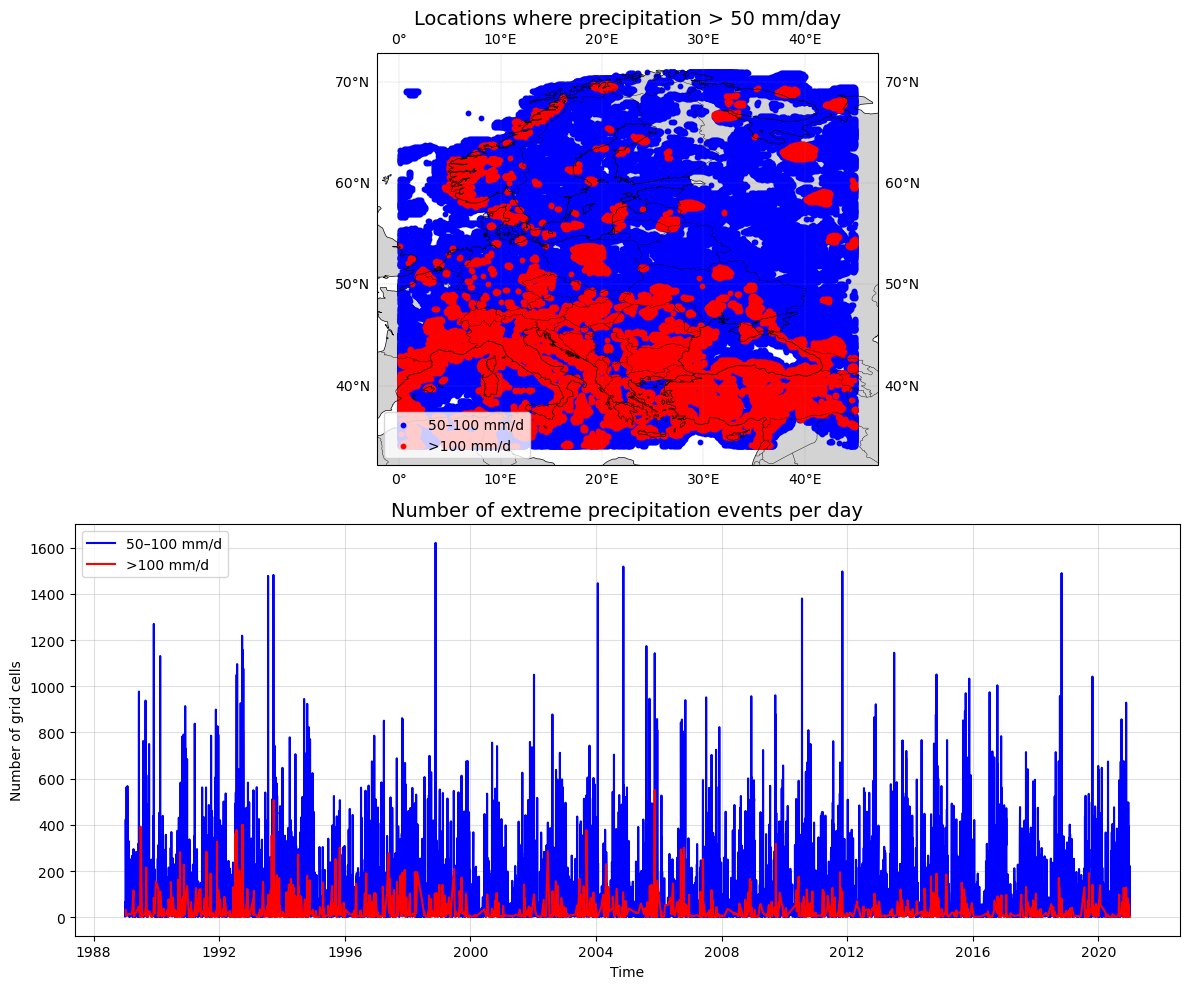

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# --- Separate categories ---
low = exceeding_df[(exceeding_df['pr'] > 50) & (exceeding_df['pr'] <= 100)]
high = exceeding_df[exceeding_df['pr'] > 100]

# --- Count events per day ---
low_counts = low.groupby('time').size()
high_counts = high.groupby('time').size()

# --- Create figure with two panels ---
fig = plt.figure(figsize=(12, 10))

# ============ 1. MAP PLOT ============
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_title("Locations where precipitation > 50 mm/day", fontsize=14)

# Add features
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')

# Scatter points
ax1.scatter(low['lon'], low['lat'], color='blue', s=10, label='50–100 mm/d', transform=ccrs.PlateCarree())
ax1.scatter(high['lon'], high['lat'], color='red', s=10, label='>100 mm/d', transform=ccrs.PlateCarree())

ax1.legend(loc='lower left')
ax1.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')

# ============ 2. TIME SERIES ============
ax2 = plt.subplot(2, 1, 2)
ax2.set_title("Number of extreme precipitation events per day", fontsize=14)

ax2.plot(low_counts.index, low_counts.values, color='blue', label='50–100 mm/d')
ax2.plot(high_counts.index, high_counts.values, color='red', label='>100 mm/d')

ax2.set_ylabel("Number of grid cells")
ax2.set_xlabel("Time")
ax2.legend()
ax2.grid(alpha=0.4)

plt.tight_layout()
plt.show()


In [3]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_cmip", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )

ds_vars = []

# Loop over variables
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    cmip = climdata.CMIP(cfg)
    cmip.fetch()          # get file list
    cmip.load()           # load dataset
    europe_box = cfg.bounds.europe
    cmip.extract(box=europe_box)
    ds_vars.append(cmip.ds)

# Merge all variables
ds_merged = xr.merge(ds_vars)

# Format NetCDF filename
region_bounds = cfg.bounds[cfg.region]
filename = cfg.output.filename_nc.format(
    provider=cfg.dataset,
    parameter="surface",
    lat_range=f"{region_bounds['lat_min']}-{region_bounds['lat_max']}",
    lon_range=f"{region_bounds['lon_min']}-{region_bounds['lon_max']}",
    start=cfg.time_range.start_date.replace("-", ""),
    end=cfg.time_range.end_date.replace("-", "")
)
for var in ds_merged.data_vars:
    ds_merged[var] =  xclim.core.units.convert_units_to(
        ds_merged[var], cfg.mappings["info"][var].units
    )
cmip.ds = ds_merged
cmip.save_netcdf(filename)

📂 Processing variable: tasmax
📂 Processing variable: tasmin
📂 Processing variable: pr
Saved NetCDF to cmip_surface_LAT34.0-71.0_LON-25.0-45.0_20100801_20100831.nc


In [3]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_mswx", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )

ds_vars = []
# Loop over variables in config
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    mswx = climdata.MSWX(cfg)
    ds_var = mswx.load(var)

    # Subset to Europe bounds
    europe_box = cfg.bounds.europe
    ds_var = mswx.extract(point=(52,16))
    ds_vars.append(mswx.dataset)

# Merge all variables into one dataset
ds = xr.merge(ds_vars)

# Save NetCDF
region_bounds = cfg.bounds[cfg.region]
filename = cfg.output.filename_csv.format(
        provider=cfg.dataset,
        parameter = "surface",
        lat=f"{52}",
        lon=f"{16}",
        start=cfg.time_range.start_date.replace("-", ""),
        end=cfg.time_range.end_date.replace("-", ""),
    )
print(f"💾 Saving merged dataset to {filename}")
for var in ds.data_vars:
    ds[var] =  xclim.core.units.convert_units_to(
        ds[var], cfg.mappings["info"][var].units
    )
mswx.dataset = ds
mswx.save_csv(filename)

📂 Processing variable: tasmax
✅ All 31 tasmax files already exist locally.
📂 Processing variable: tasmin
✅ All 31 tasmin files already exist locally.
📂 Processing variable: pr
✅ All 31 pr files already exist locally.
💾 Saving merged dataset to mswx_surface_LAT_52_LON_16_20100801_20100831.csv
Saved CSV to mswx_surface_LAT_52_LON_16_20100801_20100831.csv


In [9]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim

with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_cmip", overrides= [
            "data_dir=/beegfs/muduchuru/data",
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )

ds_vars = []

# Loop over variables
for var in cfg.variables:
    print(f"📂 Processing variable: {var}")
    cmip = climdata.CMIP(cfg)
    cmip.fetch()          # get file list
    cmip.load()           # load dataset
    europe_box = cfg.bounds.europe
    cmip.extract(point=(52,16))
    ds_vars.append(cmip.ds)

# Merge all variables
ds_merged = xr.merge(ds_vars)

# Format NetCDF filename
region_bounds = cfg.bounds[cfg.region]
filename = cfg.output.filename_csv.format(
    provider=cfg.dataset,
    parameter="surface",
    lat=f"{52}",
    lon=f"{16}",
    start=cfg.time_range.start_date.replace("-", ""),
    end=cfg.time_range.end_date.replace("-", "")
)
for var in ds_merged.data_vars:
    ds_merged[var] =  xclim.core.units.convert_units_to(
        ds_merged[var], cfg.mappings["info"][var].units
    )
cmip.ds = ds_merged
cmip.save_csv(filename)
# cmip.save_netcdf(filename)

📂 Processing variable: tasmax
📂 Processing variable: tasmin
📂 Processing variable: pr
Saved CSV to cmip_surface_LAT_52_LON_16_20100801_20100831.csv


In [2]:
import argparse
import climdata
from hydra import initialize, compose
import xarray as xr
import xclim
import pandas as pd
df_vars = []
with initialize(config_path="../climdata/conf", version_base=None):
    cfg = compose(
        config_name="config_dwd", overrides= [
            f"time_range.start_date=2010-08-01",
            f"time_range.end_date=2010-08-31",
            ]
    )
# Loop over variables
for var in cfg.variables:

    print(f"📂 Processing variable: {var}")
    dwd = climdata.DWD(cfg)
    dwd.load(var, 52, 16, buffer_km=100)           # load dataset
    dwd.format(var, 52, 16)
    df_vars.append(dwd.df)

# Merge all variables
df = pd.concat(df_vars,axis=0)

filename = cfg.output.filename_csv.format(
    provider=cfg.dataset,
    parameter="surface",
    lat=f"{52}",
    lon=f"{16}",
    start=cfg.time_range.start_date.replace("-", ""),
    end=cfg.time_range.end_date.replace("-", "")
)
dwd.df = df
dwd.save_csv(filename)
# cmip.save_netcdf(filename)

📂 Processing variable: tasmax
📂 Processing variable: tasmin
📂 Processing variable: pr
✅ Saved time series to: dwd_surface_LAT_52_LON_16_20100801_20100831.csv


'dwd_surface_LAT_52_LON_16_20100801_20100831.csv'

In [4]:
    dwd = climdata.DWD(cfg)
    dwd.load(var, 52, 16, buffer_km=100)           # load dataset

,station_id,resolution,dataset,parameter,date,value,quality
0,06170,daily,climate_summary,precipitation_height,2010-08-01 00:00:00+00:00,0.0,10.0
1,06170,daily,climate_summary,precipitation_height,2010-08-02 00:00:00+00:00,15.8,10.0
2,06170,daily,climate_summary,precipitation_height,2010-08-03 00:00:00+00:00,6.1,10.0
3,06170,daily,climate_summary,precipitation_height,2010-08-04 00:00:00+00:00,0.0,10.0
4,06170,daily,climate_summary,precipitation_height,2010-08-05 00:00:00+00:00,0.0,10.0
5,06170,daily,climate_summary,precipitation_height,2010-08-06 00:00:00+00:00,6.5,10.0
6,06170,daily,climate_summary,precipitation_height,2010-08-07 00:00:00+00:00,3.8,10.0
7,06170,daily,climate_summary,precipitation_height,2010-08-08 00:00:00+00:00,0.0,10.0
8,06170,daily,climate_summary,precipitation_height,2010-08-09 00:00:00+00:00,12.4,10.0
9,06170,daily,climate_summary,precipitation_height,2010-08-10 00:00:00+00:00,0.0,10.0


In [7]:
dwd.df

,station_id,resolution,dataset,parameter,date,value,quality
0,06170,daily,climate_summary,precipitation_height,2010-08-01 00:00:00+00:00,0.0,10.0
1,06170,daily,climate_summary,precipitation_height,2010-08-02 00:00:00+00:00,15.8,10.0
2,06170,daily,climate_summary,precipitation_height,2010-08-03 00:00:00+00:00,6.1,10.0
3,06170,daily,climate_summary,precipitation_height,2010-08-04 00:00:00+00:00,0.0,10.0
4,06170,daily,climate_summary,precipitation_height,2010-08-05 00:00:00+00:00,0.0,10.0
5,06170,daily,climate_summary,precipitation_height,2010-08-06 00:00:00+00:00,6.5,10.0
6,06170,daily,climate_summary,precipitation_height,2010-08-07 00:00:00+00:00,3.8,10.0
7,06170,daily,climate_summary,precipitation_height,2010-08-08 00:00:00+00:00,0.0,10.0
8,06170,daily,climate_summary,precipitation_height,2010-08-09 00:00:00+00:00,12.4,10.0
9,06170,daily,climate_summary,precipitation_height,2010-08-10 00:00:00+00:00,0.0,10.0
